<a href="https://colab.research.google.com/github/afifrizkyandika11551100310/NAME_ENTITY_RECOGNITION/blob/main/23521011_Task1_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Named-Entity Recognition (NER)**

23521011 - Dionisius Pratama

Akan dilakukan NER tagging dari data email. Sebelumnya, akan dibuat terlebih dahulu model NER dengan memanfaatkan sebuah dataset NER. Setelah model dibuat, model yang terbaik hasilnya (F1-Score) akan digunakan untuk melakukan labeling NER tag ke data email.

#Preprations

## Installation

In [ ]:
!pip install seqeval
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install text_hammer

##Imports for All Module

In [ ]:
%tensorflow_version 2.x
# %tensorflow_version 1.x # untuk CRF Layer
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import nltk
import numpy as np
import pandas as pd
import text_hammer as th
nltk.download('punkt')

# DL Models
from google.colab import files
from keras import models 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model, Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras_contrib.layers import CRF
from keras_contrib.layers.crf import CRF, crf_loss, crf_viterbi_accuracy
from keras_contrib.utils import save_load_utils
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from seqeval.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Machine Learning models
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

## Dataset NER

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [ ]:
data = data.fillna(method="ffill") # mengisi data NaN di kolom sentence #

In [ ]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
words = list(set(data["Word"].values))

In [ ]:
words.append("ENDPAD")

In [ ]:
n_words = len(words); n_words

35179

In [ ]:
tags = list(set(data["Tag"].values))

In [ ]:
tags

['B-nat',
 'I-gpe',
 'I-geo',
 'B-geo',
 'B-gpe',
 'I-tim',
 'I-art',
 'B-per',
 'B-art',
 'B-eve',
 'I-eve',
 'O',
 'B-org',
 'B-tim',
 'I-org',
 'I-per',
 'I-nat']

In [ ]:
n_tags = len(tags); n_tags

17

##Sentence Preparations

### Sentence Getter

In [ ]:
# gabung kata yang terpisah di dataframe menjadi satu kalimat
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sent = getter.get_next()

In [ ]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [ ]:
sentences = getter.sentences

### Conversion word2idx tag2idx and padding

In [ ]:
max_len = 250
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
# padding
# ensure that all sequences in a list have the same length
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1) 

In [ ]:
X[1]

array([ 2027,  6208,   291, 35018, 31007, 25884, 11920, 23339, 25884,
       14606,  8113, 12333,  7085,  6521, 27040, 16073, 27139,  2705,
       29653, 14798, 19114,  3314,  8589, 32784,  8248, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178,

In [ ]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
y[1]

array([ 4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 11,
       11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

### One-hot Encoding

In [ ]:
# convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

##Split train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (38367, 250)
Size of training output data :  (38367, 250, 17)
Size of testing input data :  (9592, 250)
Size of testing output data :  (9592, 250, 17)


#Model Building

##Model 1: BiLSTM

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.25)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.25))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [ ]:
model = Model(input, out)

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 50)           1758950   
                                                                 
 dropout (Dropout)           (None, 250, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 250, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 250, 17)          3417      
 ibuted)                                                         
                                                                 
Total params: 1,883,167
Trainable params: 1,883,167
Non-train

In [ ]:
with tf.device('/device:GPU:0'): 
  history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
240/240 [==============================] - 464s 2s/step - loss: 0.0908 - accuracy: 0.9833 - val_loss: 0.0330 - val_accuracy: 0.9898
Epoch 2/5
240/240 [==============================] - 443s 2s/step - loss: 0.0233 - accuracy: 0.9934 - val_loss: 0.0159 - val_accuracy: 0.9956
Epoch 3/5
240/240 [==============================] - 429s 2s/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0120 - val_accuracy: 0.9965
Epoch 4/5
240/240 [==============================] - 430s 2s/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0113 - val_accuracy: 0.9967
Epoch 5/5
240/240 [==============================] - 432s 2s/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0101 - val_accuracy: 0.9970


In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
hist

,loss,accuracy,val_loss,val_accuracy
0,0.090794,0.983287,0.032997,0.989837
1,0.023317,0.993360,0.015880,0.995601
2,0.013512,0.996149,0.012003,0.996475
3,0.010779,0.996885,0.011337,0.996661
4,0.009486,0.997227,0.010091,0.996994


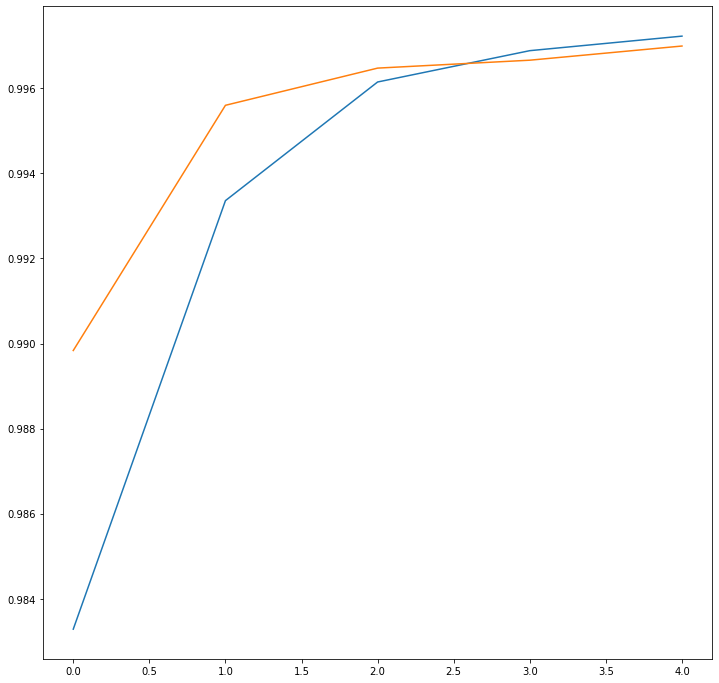

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [ ]:
model.save('lstm_model_5epoch_250input.h5')

In [ ]:
model.save('lstm_model_5epoch_250input.tf')

INFO:tensorflow:Assets written to: lstm_model_5epoch_250input.tf/assets


### Predict using Model 1

In [ ]:
test_pred = model.predict(X_test, verbose=1)

300/300 [==============================] - 68s 224ms/step


In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [ ]:
print("F1-score LSTM saja: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score LSTM saja: 79.4%


In [ ]:
i = 34
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 35178:
        print("{:15}: {:5} {}".format(words[w], tags[t], tags[pred]))

Word           ||True ||Pred
It             : O     O
was            : O     O
a              : O     O
stunning       : O     O
upset          : O     O
,              : O     O
even           : O     O
for            : O     O
the            : O     O
most           : O     O
loyal          : O     O
of             : O     O
Niger          : B-gpe B-gpe
's             : O     O
football       : O     O
faithful       : O     O
.              : O     O


##Model 2: BiLISTM + CRF

Gunakan Tensorflow 1.x

In [ ]:
input_2 = Input(shape=(max_len,))
model_2 = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len)(input_2)
model_2 = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model_2)
model_2 = TimeDistributed(Dense(50, activation="relu"))(model_2)
crf = CRF(n_tags)
out_2 = crf(model_2)

In [ ]:
model_2 = Model(input_2, out_2)

In [ ]:
model_2.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 20)           703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 250, 17)           1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'): 
  history_2 = model_2.fit(X_train, np.array(y_train), batch_size=128, epochs=5, validation_split=0.1, verbose=1)


Train on 34530 samples, validate on 3837 samples
Epoch 1/5
34530/34530 [==============================] - 306s 9ms/step - loss: 0.1134 - crf_viterbi_accuracy: 0.9713 - val_loss: 0.0286 - val_crf_viterbi_accuracy: 0.9910
Epoch 2/5
34530/34530 [==============================] - 303s 9ms/step - loss: 0.0203 - crf_viterbi_accuracy: 0.9932 - val_loss: 0.0138 - val_crf_viterbi_accuracy: 0.9951
Epoch 3/5
34530/34530 [==============================] - 293s 8ms/step - loss: 0.0098 - crf_viterbi_accuracy: 0.9959 - val_loss: 0.0078 - val_crf_viterbi_accuracy: 0.9962
Epoch 4/5
34530/34530 [==============================] - 291s 8ms/step - loss: 0.0046 - crf_viterbi_accuracy: 0.9968 - val_loss: 0.0041 - val_crf_viterbi_accuracy: 0.9967
Epoch 5/5
34530/34530 [==============================] - 290s 8ms/step - loss: 0.0016 - crf_viterbi_accuracy: 0.9973 - val_loss: 0.0018 - val_crf_viterbi_accuracy: 0.9969


In [ ]:
hist_2 = pd.DataFrame(history_2.history)

In [ ]:
hist_2

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.028637,0.991018,0.113362,0.971290
1,0.013826,0.995073,0.020320,0.993174
2,0.007784,0.996187,0.009762,0.995871
3,0.004055,0.996728,0.004629,0.996824
4,0.001827,0.996944,0.001587,0.997304


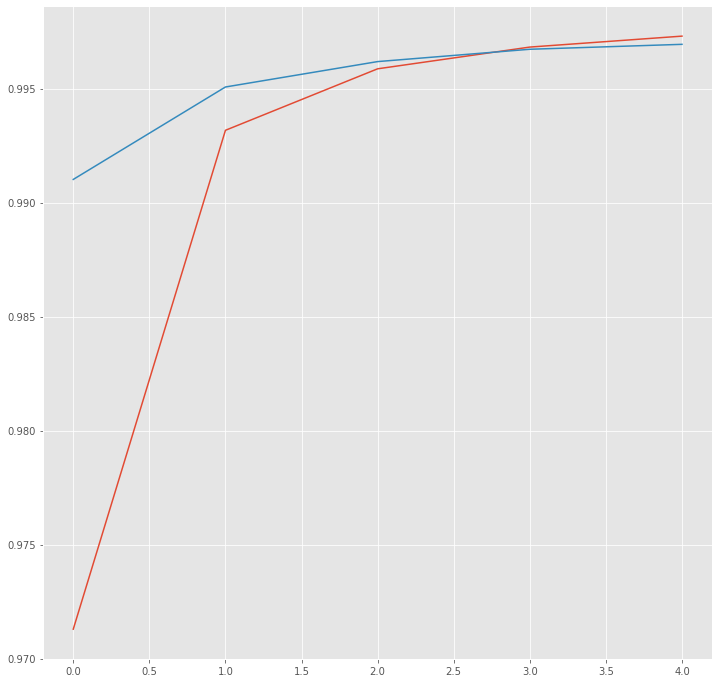

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_2["crf_viterbi_accuracy"])
plt.plot(hist_2["val_crf_viterbi_accuracy"])
plt.show()

In [ ]:
# save model traditionally
save_load_utils.save_all_weights(model_2, 'lstm_crf_model_5epoch_250input.h5')
save_load_utils.save_all_weights(model_2, 'lstm_crf_model_5epoch_250input.tf')

# save model using Keras --> need custom objects later
model_2.save("lstm-crf.h5")

### Predict using Model 2

In [ ]:
test_pred_2 = model_2.predict(X_test, verbose=1)

9592/9592 [==============================] - 206s 21ms/step


In [ ]:
idx2tag_2 = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag_2[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels_2 = pred2label(test_pred_2)
test_labels_2 = pred2label(y_test)

In [ ]:
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

print("ACC-score LSTM-CRF: {:.1%}".format(accuracy_score(test_labels_2, pred_labels_2)))
print("F1-score LSTM-CRF: {:.1%}".format(f1_score(test_labels_2, pred_labels_2)))
print("PREC-score LSTM-CRF: {:.1%}".format(precision_score(test_labels_2, pred_labels_2)))
print("REC-score LSTM-CRF: {:.1%}".format(recall_score(test_labels_2, pred_labels_2)))

print(classification_report(test_labels_2, pred_labels_2, digits=2))

ACC-score LSTM-CRF: 99.7%
F1-score LSTM-CRF: 81.5%
PREC-score LSTM-CRF: 81.9%
REC-score LSTM-CRF: 81.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        82
         eve       0.00      0.00      0.00        66
         geo       0.83      0.89      0.86      7534
         gpe       0.95      0.93      0.94      3198
         nat       0.00      0.00      0.00        54
         org       0.70      0.64      0.67      4039
         per       0.73      0.75      0.74      3466
         tim       0.89      0.83      0.86      4064

   micro avg       0.82      0.81      0.81     22503
   macro avg       0.51      0.50      0.51     22503
weighted avg       0.81      0.81      0.81     22503



In [ ]:
i_2 = 1997
p_2 = model_2.predict(np.array([X_test[i_2]]))
p_2 = np.argmax(p_2, axis=-1)
true_2 = np.argmax(y_test[i_2], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i_2], true_2, p_2[0]):
    if w != 35178:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
validated      : B-org O
Undercover     : I-org O
prevent        : I-org B-per
Rasmussen      : B-per I-per
1922           : I-per I-per
Hey            : O     O
Yuganskneftgaz : O     O
gunfight       : O     O
Jamie          : O     O
Saxby          : O     O
Autonomy       : O     O
banners        : O     O
welcomes       : O     O
justly         : O     O


##Model 3: ML

In [ ]:
dfml = data
dfml = dfml[:50000] # hanya diambil 50000 data --> RAM out usage
dfml.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
dfml.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,48
1,B-eve,39
2,B-geo,1490
3,B-gpe,968
4,B-nat,18
5,B-org,959
6,B-per,789
7,B-tim,880
8,I-art,27
9,I-eve,33


In [ ]:
X_ml = dfml.drop('Tag', axis=1)
v_ml = DictVectorizer(sparse=False)
X_ml = v_ml.fit_transform(X_ml.to_dict('records'))
y_ml = dfml.Tag.values

classes = np.unique(y_ml)
classes = classes.tolist()

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size = 0.33, random_state=0)
X_train_ml.shape, y_train_ml.shape

((33500, 9774), (33500,))

In [ ]:
nb = MultinomialNB(alpha=0.01)

with tf.device('/device:GPU:0'):
  nb.partial_fit(X_train_ml, y_train_ml, classes)

In [ ]:
new_classes = classes.copy()
new_classes.pop()
new_classes

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim']

In [ ]:
print(classification_report(y_pred=nb.predict(X_test_ml), y_true=y_test_ml, labels = new_classes))

              precision    recall  f1-score   support

       B-art       0.09      0.28      0.13        18
       B-eve       0.29      0.29      0.29        14
       B-geo       0.66      0.58      0.62       476
       B-gpe       0.65      0.73      0.68       320
       B-nat       0.18      0.67      0.29         3
       B-org       0.48      0.48      0.48       301
       B-per       0.38      0.48      0.42       258
       B-tim       0.60      0.72      0.65       272
       I-art       0.08      0.20      0.12         5
       I-eve       0.47      0.64      0.54        11
       I-geo       0.43      0.49      0.46       115
       I-gpe       0.00      0.00      0.00        11
       I-nat       0.00      0.00      0.00         3
       I-org       0.47      0.48      0.48       200
       I-per       0.52      0.45      0.49       306
       I-tim       0.16      0.26      0.20        90

   micro avg       0.50      0.54      0.52      2403
   macro avg       0.34   

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(nb, open(filename, 'wb'))

#Predict Email Data!

In [ ]:
mod = load_model("lstm-crf.h5", custom_objects={"CRF": CRF, 'crf_loss': crf_loss, 'crf_viterbi_accuracy': crf_viterbi_accuracy})

## Cleaning Email Data

In [ ]:
df = pd.read_csv('spam.csv',encoding='ISO-8859-1',usecols=['Category','Message'])
df.rename(columns = {'Category':'Target', 'Message':'Email'}, inplace = True)

In [ ]:
df

,Target,Email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ã¼ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
def text_cleaning(df,col_name):
    #-----Remove Stopwords----
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_stopwords(x))

    #----Remove Special Character----
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))

    #---Remove accented characters---
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))

    # ---Removing HTML tags and URL---
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_urls(x))
    
    #--- Converting into root words--
    df[col_name] = df[col_name].progress_apply(lambda x: th.make_base(x))                                      
    return df

In [ ]:
df = text_cleaning(df, 'Email')

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

In [ ]:
df.to_csv("cleanspam.csv")

## Predict using Cleaned Data

In [ ]:
# cleaned data
df = pd.read_csv("cleanspam.csv")
df

,Target,Email
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar Joking wif u oni
2,spam,free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,u dun early hor u c say
4,ham,nah I do not think go usf life
...,...,...
5567,spam,this 2nd time try 2 contact u U win A750 Pound...
5568,ham,Will A14 b go esplanade fr home
5569,ham,pity mood that Soany suggestion
5570,ham,the guy bitch I act like i would interested bu...


In [ ]:
df.isnull().sum()

Target    0
Email     2
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
NE_LSTMCRF = {}

counter = 1

with tf.device('/device:GPU:0'): 
  for data in df["Email"]:
      print(counter)
      
      dokumen = data.lower()
      test_sentence = word_tokenize(dokumen)

      # print(test_sentence)
      
      # predict padded sentences
      x_pred_crflstm = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

      # #Proses NER pakai LSTM + CRF
      p_pred_2 = mod.predict(np.array([x_pred_crflstm[0]]))
      p_pred_2 = np.argmax(p_pred_2, axis=-1)
      NE_LSTMCRF[data] = p_pred_2
      # print(p_pred_2)
      
      counter += 1

In [ ]:
print("{:18}||{}".format("Word", "Prediction LSTM-CRF"))
print(40 * "=")
baris=1

# sample on new data
for w, pred in zip(word_tokenize(df["Email"][8]), NE_LSTMCRF[data][0]):
    print("{}. {:15}: {:5}".format(baris,w, tags[pred]))
    baris +=1

Word              ||Prediction LSTM-CRF
1. WINNER         : I-per
2. as             : I-nat
3. value          : I-nat
4. network        : I-nat
5. customer       : I-nat
6. select         : I-nat
7. receivea       : I-nat
8. A900           : I-nat
9. prize          : I-nat
10. reward         : I-nat
11. to             : I-nat
12. claim          : I-nat
13. 09061701461    : I-nat
14. claim          : I-nat
15. code           : I-nat
16. KL341          : I-nat
17. Valid          : I-nat
18. 12             : I-nat
19. hour           : I-nat
20. only           : I-nat
